In [1]:
import os
import pathlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
import random
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Activation, GlobalMaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import splitfolders

In [2]:
# splits dataset it into three subfolders: train, val (validation), and test.

splitfolders.ratio(r"C:\Users\Ajay\Desktop\Inno_Projects\Currency Note Classification Vitis\Dataset", output="output",
    seed=1337, ratio=(.75, .2, .05), group_prefix=None, move=False)

Copying files: 132 files [00:01, 127.99 files/s]


In [3]:
data_dir = pathlib.Path('output/')
train_dir = 'output/train'
val_dir = 'output/val'
test_dir = 'output/test'

In [4]:
class_name = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_name)

['test' 'train' 'val']


In [5]:
for dirpath, dirnames, filenames in os.walk('output'):
  print(f"{len(dirnames)} folder and {len(filenames)} images in {dirpath}")

3 folder and 0 images in output
6 folder and 0 images in output\test
0 folder and 2 images in output\test\Fiftynote
0 folder and 2 images in output\test\FiveHundrednote
0 folder and 2 images in output\test\OneHundrednote
0 folder and 2 images in output\test\Tennote
0 folder and 2 images in output\test\Twentynote
0 folder and 2 images in output\test\TwoHundrednote
6 folder and 0 images in output\train
0 folder and 16 images in output\train\Fiftynote
0 folder and 16 images in output\train\FiveHundrednote
0 folder and 16 images in output\train\OneHundrednote
0 folder and 16 images in output\train\Tennote
0 folder and 16 images in output\train\Twentynote
0 folder and 16 images in output\train\TwoHundrednote
6 folder and 0 images in output\val
0 folder and 4 images in output\val\Fiftynote
0 folder and 4 images in output\val\FiveHundrednote
0 folder and 4 images in output\val\OneHundrednote
0 folder and 4 images in output\val\Tennote
0 folder and 4 images in output\val\Twentynote
0 folder an

In [6]:
def view_random_image(target_dir, target_class):
    target_folder = target_dir + target_class
    random_image = random.sample(os.listdir(target_folder), 1)
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")
    
    print(f"Image Shape : {img.shape}")
    plt.show()

Image Shape : (168, 300, 3)


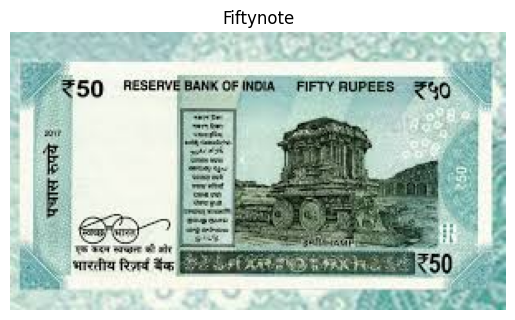

In [7]:
for i in range(1,2):
    img_n = view_random_image(target_dir='output/train/', target_class='Fiftynote')

In [8]:
# Sets the global random seed.
tf.random.set_seed(46)

# preprocess data
train_datagen = ImageDataGenerator(rescale=1/255.0,
                                   rotation_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   vertical_flip=True,
                                   horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1/255.0)
test_datagen = ImageDataGenerator(rescale=1/255.0)

In [9]:
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=46)

valid_data = valid_datagen.flow_from_directory(val_dir,
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=46)

test_data = test_datagen.flow_from_directory(test_dir,
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=46)

Found 96 images belonging to 6 classes.
Found 24 images belonging to 6 classes.
Found 12 images belonging to 6 classes.


In [10]:
train_data.class_indices

{'Fiftynote': 0,
 'FiveHundrednote': 1,
 'OneHundrednote': 2,
 'Tennote': 3,
 'Twentynote': 4,
 'TwoHundrednote': 5}

In [11]:
train_y=train_data.classes
val_y=valid_data.classes
test_y=test_data.classes

In [12]:
print("train_y.shape: ", train_y.shape)
print("val_y.shape: ", val_y.shape)
print("test_y.shape: ", test_y.shape)

train_y.shape:  (96,)
val_y.shape:  (24,)
test_y.shape:  (12,)


In [13]:
base_model = tf.keras.applications.DenseNet121(input_shape=(224, 224, 3),
                                                        include_top=False,
                                                        weights='imagenet')
base_model.trainable = False

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [17]:
global_average_layer = GlobalAveragePooling2D()
prediction_layer = Dense(6)
softmax = Activation('softmax')

inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = Dropout(0.25)(x)
x = global_average_layer(x)
outputs = prediction_layer(x)
outputs = softmax(outputs)

model = Model(inputs, outputs)

In [18]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         6,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 6)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,043,654 (26.87 MB)

 Trainable params: 6,150 (24.02 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [19]:
plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [20]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

# train model
history = model.fit(train_data, epochs=50, validation_data=valid_data)

C:\Users\Ajay\anaconda3\envs\py310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 24s 9s/step - accuracy: 0.0729 - loss: 2.3063 - val_accuracy: 0.1667 - val_loss: 1.9468
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 6s/step - accuracy: 0.1736 - loss: 2.0017 - val_accuracy: 0.1667 - val_loss: 1.9196
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - accuracy: 0.2222 - loss: 1.9307 - val_accuracy: 0.1667 - val_loss: 1.9344
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - accuracy: 0.1667 - loss: 1.9732 - val_accuracy: 0.2083 - val_loss: 1.9153
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 7s/step - accuracy: 0.1285 - loss: 1.9203 - val_accuracy: 0.2083 - val_loss: 1.8524
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 6s/step - accuracy: 0.2500 - loss: 1.8044 - val_accuracy: 0.1667 - val_loss: 1.7936
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - accuracy: 0.3073 - loss: 1.7625 - val_accuracy: 0.2500 - val_loss: 1.7511
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - accuracy: 0.2951 - loss: 1.6762 - val_accuracy: 0.2083 - val_loss: 1.7246
Epoch 9/50

In [21]:
model.save('my_model.keras')

In [22]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(loss))

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title("Loss Curves")
  plt.xlabel("Epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title("Accuracy Curves")
  plt.xlabel("Epochs")
  plt.legend()

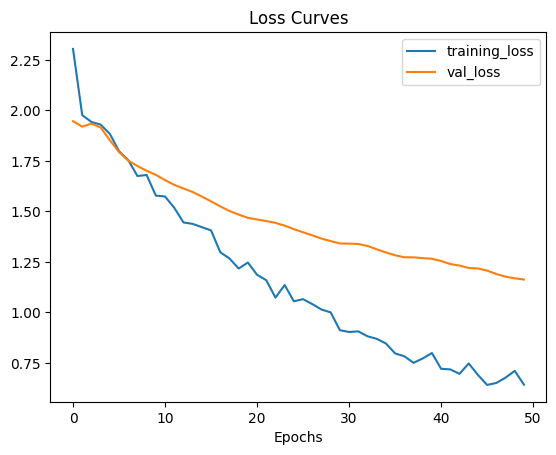

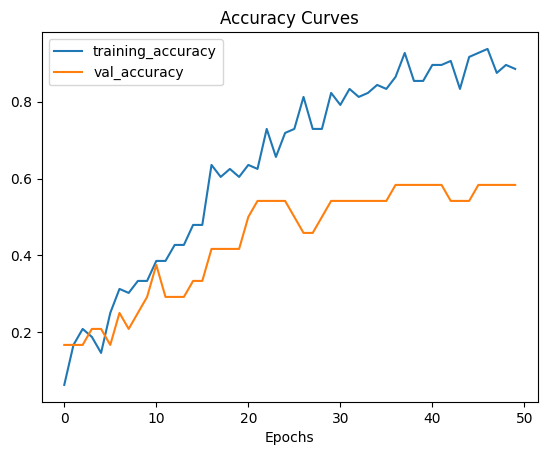

In [23]:
plot_loss_curves(history)

In [24]:
val_pred = model.predict(valid_data)
val_pred = val_pred.argmax(axis=1)
print(classification_report(val_pred, val_y))

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
              precision    recall  f1-score   support

           0       1.00      0.44      0.62         9
           1       0.50      1.00      0.67         2
           2       0.25      0.20      0.22         5
           3       0.50      1.00      0.67         2
           4       0.50      0.67      0.57         3
           5       0.75      1.00      0.86         3

    accuracy                           0.58        24
   macro avg       0.58      0.72      0.60        24
weighted avg       0.67      0.58      0.57        24



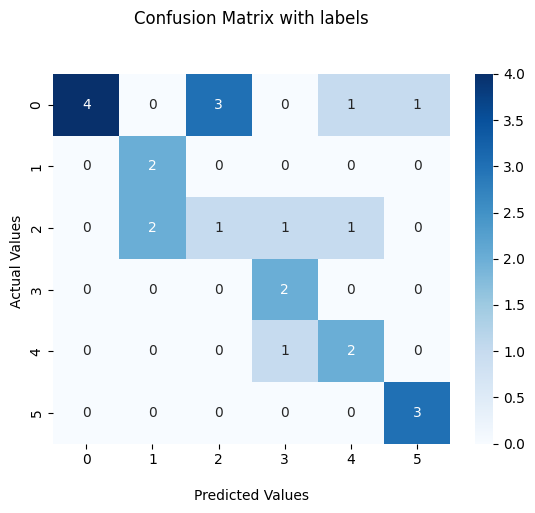

In [25]:
cfm_val = confusion_matrix(val_pred, val_y)
ax = sns.heatmap(cfm_val, annot=True, 
            cmap='Blues')

# Preparation for plotting confusion matrix
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Display the visualization of the Confusion Matrix.
plt.show()

In [26]:
test_pred = model.predict(test_data)
test_pred = test_pred.argmax(axis=1)
print(classification_report(test_pred, test_y))

C:\Users\Ajay\anaconda3\envs\py310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
              precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       0.50      1.00      0.67         1
           2       0.50      0.33      0.40         3
           3       0.50      1.00      0.67         1
           4       0.50      1.00      0.67         1
           5       0.50      1.00      0.67         1

    accuracy                           0.58        12
   macro avg       0.58      0.79      0.61        12
weighted avg       0.71      0.58      0.56        12



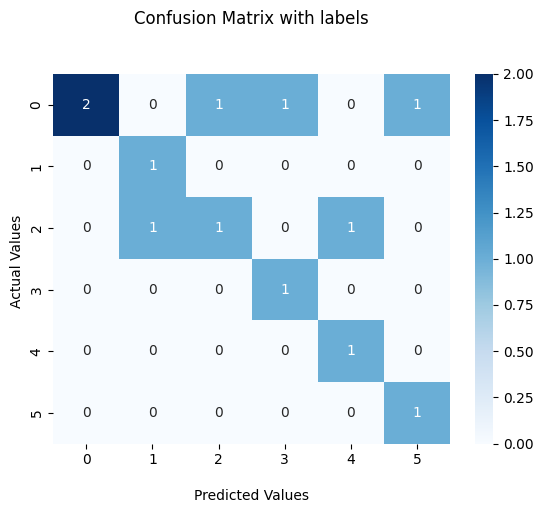

In [27]:
cfm_test = confusion_matrix(test_pred, test_y)
ax = sns.heatmap(cfm_test, annot=True, 
            cmap='Blues')

# Preparation for plotting confusion matrix
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Display the visualization of the Confusion Matrix.
plt.show()

In [28]:
!pip install opencv-python

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
You have a 50 rupees note.


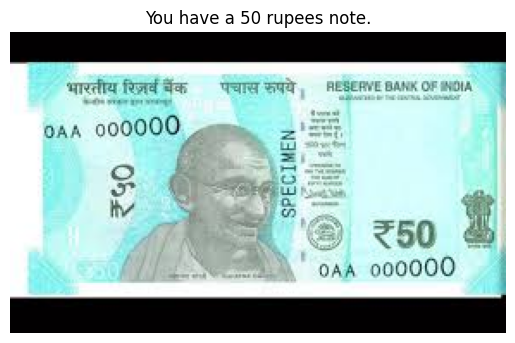

In [31]:
import matplotlib.pyplot as plt
from keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the trained model
model = load_model('my_model.keras')

# Define class-specific messages
class_messages = {
    0: "You have a 50 rupees note.",
    1: "You have a 500 rupees note.",
    2: "You have a 100 rupees note.",
    3: "You have a 10 rupees note.",
    4: "You have a 20 rupees note.",
    5: "You have a 200 rupees note."
}

# Load the image for prediction
image_path = r"C:\Users\Ajay\Desktop\Inno_Projects\Currency Note Classification Vitis\Dataset\Fiftynote\6.jpg"

img = image.load_img(image_path, target_size=(224, 224))

# Preprocess the image
img = image.img_to_array(img)  # Convert the image to a NumPy array
img = img / 255.0  # Normalize the image
img = np.expand_dims(img, axis=0)  # Add a batch dimension

# Predict the label
label = model.predict(img)

# Determine the predicted class
predicted_class_index = np.argmax(label)
predicted_message = class_messages[predicted_class_index]

# Print the customized message
print(predicted_message)

# Display the image with the predicted label
plt.imshow(image.load_img(image_path))
plt.title(predicted_message)
plt.axis('off')
plt.show()


In [32]:
import cv2
import numpy as np
from keras.models import load_model

# Load the trained model
model = load_model('my_model.keras')

# Define class-specific messages
class_messages = {
    0: "You have a 50 rupees note.",
    1: "You have a 500 rupees note.",
    2: "You have a 100 rupees note.",
    3: "You have a 10 rupees note.",
    4: "You have a 20 rupees note.",
    5: "You have a 200 rupees note."
}

# Function to preprocess the image for prediction
def preprocess_frame(frame):
    frame_resized = cv2.resize(frame, (224, 224))  # Resize to model input size
    frame_array = np.array(frame_resized, dtype="float32") / 255.0  # Normalize
    frame_array = np.expand_dims(frame_array, axis=0)  # Add batch dimension
    return frame_array

# Access the webcam
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Could not access the webcam.")
else:
    print("Press 'q' to quit the application.")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame. Exiting...")
        break

    # Get frame dimensions
    height, width, _ = frame.shape

    # Define ROI coordinates (center rectangle)
    roi_x1 = int(width * 0.3)
    roi_y1 = int(height * 0.3)
    roi_x2 = int(width * 0.7)
    roi_y2 = int(height * 0.7)

    # Draw rectangle on the frame
    cv2.rectangle(frame, (roi_x1, roi_y1), (roi_x2, roi_y2), (0, 255, 0), 2)

    # Extract the ROI for prediction
    roi = frame[roi_y1:roi_y2, roi_x1:roi_x2]

    # Preprocess the ROI
    preprocessed_roi = preprocess_frame(roi)

    # Predict the currency note
    predictions = model.predict(preprocessed_roi)
    predicted_class_index = np.argmax(predictions)
    predicted_message = class_messages[predicted_class_index]

    # Display the result on the webcam feed
    cv2.putText(
        frame,
        predicted_message,
        (10, 30),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (0, 255, 0),
        2
    )
    cv2.imshow("Currency Note Detection", frame)

    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()


Press 'q' to quit the application.
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182m

In [34]:
!pip install tf2onnx


  Using cached onnx-1.17.0-cp310-cp310-win_amd64.whl.metadata (16 kB)
Using cached onnx-1.17.0-cp310-cp310-win_amd64.whl (14.5 MB)
   ---------------------------------------- 0.0/904.0 kB ? eta -:--:--
   --------------------------------------- 904.0/904.0 kB 10.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.1
    Uninstalling protobuf-5.29.1:
      Successfully uninstalled protobuf-5.29.1


  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.68.1 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.3 which is incompatible.
tensorflow-intel 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.1 which is incompatible.


In [36]:
import tensorflow as tf
from keras.models import load_model
import tf2onnx

# Load the trained Keras model
model = load_model("my_model.keras")

# Convert the model to ONNX format
onnx_model_path = "my_model.onnx"
spec = (tf.TensorSpec((1, 224, 224, 3), tf.float32, name="input"),)
onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=13)  # Extract ONNX model
with open(onnx_model_path, "wb") as f:
    f.write(onnx_model.SerializeToString())

print(f"Model converted and saved to {onnx_model_path}")


rewriter <function rewrite_constant_fold at 0x0000019E3EC67010>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.


Model converted and saved to my_model.onnx
